In [15]:
import pandas as pd 

root_file='store-sales-time-series-forecasting'

train_df=pd.read_csv(f'{root_file}/train.csv')
test_df=pd.read_csv(f'{root_file}/test.csv')
stores_df=pd.read_csv(f'{root_file}/stores.csv')
oil_df=pd.read_csv(f'{root_file}/oil.csv')
holidays_df=pd.read_csv(f'{root_file}/holidays_events.csv')

In [16]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [17]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [18]:
holidays_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [19]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.



In [20]:
## convert date object to datetime
date_cols=['date']
for df in [train_df,test_df,oil_df,holidays_df]:
    df[date_cols]=df[date_cols].apply(pd.to_datetime)

In [21]:
train_df['date']=pd.to_datetime(train_df['date'])
train_df['year']=train_df['date'].dt.year
train_df['month']=train_df['date'].dt.month
train_df['day']=train_df['date'].dt.day
train_df['dayofweek']=train_df['date'].dt.dayofweek
train_df['dayofyear']=train_df['date'].dt.dayofyear

In [22]:
## handling duplicates
duplicated_rows=train_df[train_df.duplicated(keep=False)]
print(f"Total duplicated rows (including first occurrence): {len(duplicated_rows)}")

Total duplicated rows (including first occurrence): 0


In [23]:
train_df[train_df.isnull().any(axis=1)]

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,dayofyear


In [24]:
oil_df[oil_df.isnull().any(axis=1)]

,date,dcoilwtico
0,2013-01-01,NaN
14,2013-01-21,NaN
34,2013-02-18,NaN
63,2013-03-29,NaN
104,2013-05-27,NaN
132,2013-07-04,NaN
174,2013-09-02,NaN
237,2013-11-28,NaN
256,2013-12-25,NaN
261,2014-01-01,NaN


In [25]:
holidays_df[holidays_df.isnull().any(axis=1)]

,date,type,locale,locale_name,description,transferred


In [26]:
## Days marked as Transferred and True are not holidays; they are normal business days. We filter these out.
actual_holidays=holidays_df[holidays_df.transferred==False].copy()
actual_holidays['is_holiday']=1
train_df = train_df.merge(
    actual_holidays[['date', 'is_holiday']], 
    on='date', 
    how='left'
)
train_df.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,dayofyear,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,1,1.0
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,1,1.0
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,1,1.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,1,1.0
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,1,1.0


In [27]:
train_df['is_holiday'].fillna(0, inplace=True)

/tmp/ipykernel_5784/1766916344.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['is_holiday'].fillna(0, inplace=True)


In [29]:
## cleaning and merging oil prices:
## dcoilwtico has nan values due to non trading days of oil such as weekends and major market holidays
## oil is traded on finnacial markets which operate from monday to friday
## use forward filling so that the oil price for closed day will be same as when the market last closed 

train_df=train_df.merge(oil_df,on='date',how='left')
train_df['dcoilwtico'].fillna(method='ffill',inplace=True)
train_df['dcoilwtico'].fillna(method='bfill', inplace=True)
train_df[train_df.isnull().any(axis=1)]


/tmp/ipykernel_5784/1886889979.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['dcoilwtico'].fillna(method='ffill',inplace=True)
/tmp/ipykernel_5784/1886889979.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df['dcoilwtico'].fillna(method='ffill',inplace=True)
/tmp/ipykernel_5784/1886889979.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace 

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,dayofyear,is_holiday,dcoilwtico


In [30]:
train_df['dcoilwtico'].fillna(0, inplace=True)

/tmp/ipykernel_5784/1643377760.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['dcoilwtico'].fillna(0, inplace=True)


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 13 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   year         int32         
 7   month        int32         
 8   day          int32         
 9   dayofweek    int32         
 10  dayofyear    int32         
 11  is_holiday   float64       
 12  dcoilwtico   float64       
dtypes: datetime64[ns](1), float64(3), int32(5), int64(3), object(1)
memory usage: 244.7+ MB


## Time series decomposition (Trend and seasonality)

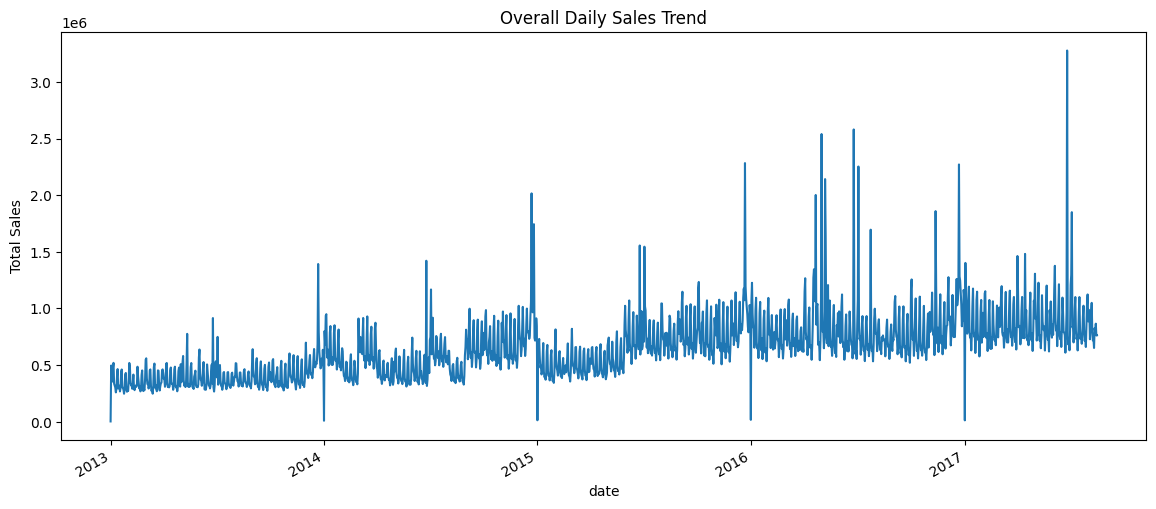

In [ ]:
## overall sales trend
import matplotlib.pyplot as plt
import seaborn as sns

daily_sales=train_df.groupby('date')['sales'].sum()

plt.figure(figsize=(14, 6))
daily_sales.plot(title='Overall Daily Sales Trend')
plt.ylabel('Total Sales')
plt.show()

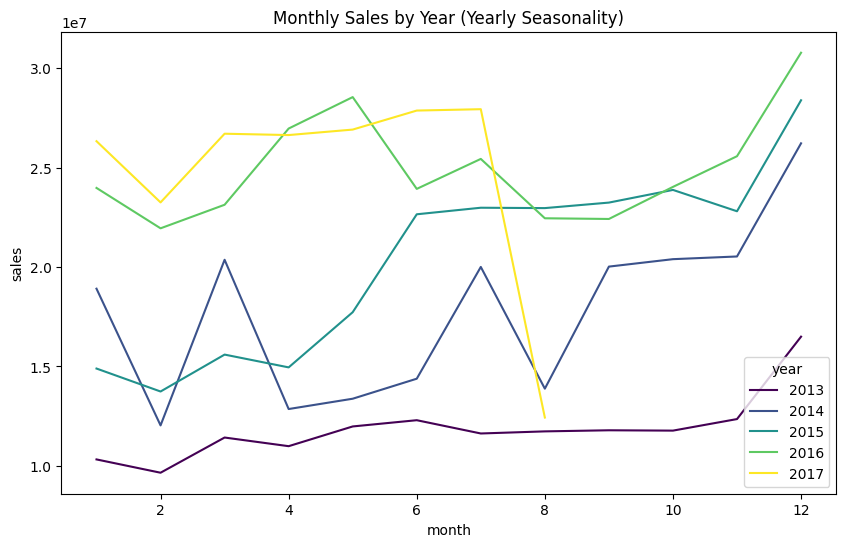

In [39]:
monthly_sales = train_df.groupby(['year', 'month'])['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales, x='month', y='sales', hue='year', palette='viridis')
plt.title('Monthly Sales by Year (Yearly Seasonality)')
plt.show()

**Overall Trend: Strong Growth Post-2015** 
- Growth: The overall sales volume shows a strong positive, non-linear growth trend.
- Step Change (2016): Sales experienced a major upward shift in 2016, maintaining a consistently higher level (above $22M/month) than the preceding years (mostly below $18M/month). This suggests a significant positive operational change or market event (e.g., store expansion).

**Yearly Seasonality: Highly Predictable**
- Peak: Sales consistently peak in December (Month 12) every year, driven by holiday demand.
- Trough: The lowest sales month is predictably February (Month 2), following the holiday spending cooldown.
- Secondary Peak: A minor recurring peak is observed around March (Month 3).

**Critical Anomalies** 

Two major drops require immediate investigation:

- August (Month 8) Drop: A massive, unnatural sales drop occurred in August 2014 and, more dramatically, in August 2017. This is the most critical issue, as it is non-seasonal and suggests an external shock (e.g., natural disaster, national strike, or major economic event).
- January (Month 1) Spike: Sales in January 2015 were unusually high, disproportionate to the trend, indicating a potential anomaly like a large inventory clearance or late holiday reporting.

In [41]:
## Investigate the reason of sales drop on August for year 2014 and year 2017
august_data = train_df[
    ((train_df['year'] == 2014) & (train_df['month'] == 8)) |
    ((train_df['year'] == 2017) & (train_df['month'] == 8))
].copy()

daily_analysis = august_data.groupby('date').agg(
    Total_Sales=('sales', 'sum'),
    Avg_Oil_Price=('dcoilwtico', 'mean'),  # Should be constant per day
    Is_Holiday=('is_holiday', 'max')       # 1 if any store was on holiday
).reset_index()

daily_analysis.sort_values('date', inplace=True)
daily_analysis

,date,Total_Sales,Avg_Oil_Price,Is_Holiday
0,2014-08-01,5.068268e+05,97.86,0.0
1,2014-08-02,6.265336e+05,97.86,0.0
2,2014-08-03,6.258982e+05,97.86,0.0
3,2014-08-04,4.711733e+05,98.26,0.0
4,2014-08-05,4.171975e+05,97.34,1.0
5,2014-08-06,4.029144e+05,96.93,0.0
6,2014-08-07,3.597015e+05,97.34,0.0
7,2014-08-08,3.977599e+05,97.61,0.0
8,2014-08-09,4.961928e+05,97.61,0.0
9,2014-08-10,5.096818e+05,97.61,1.0


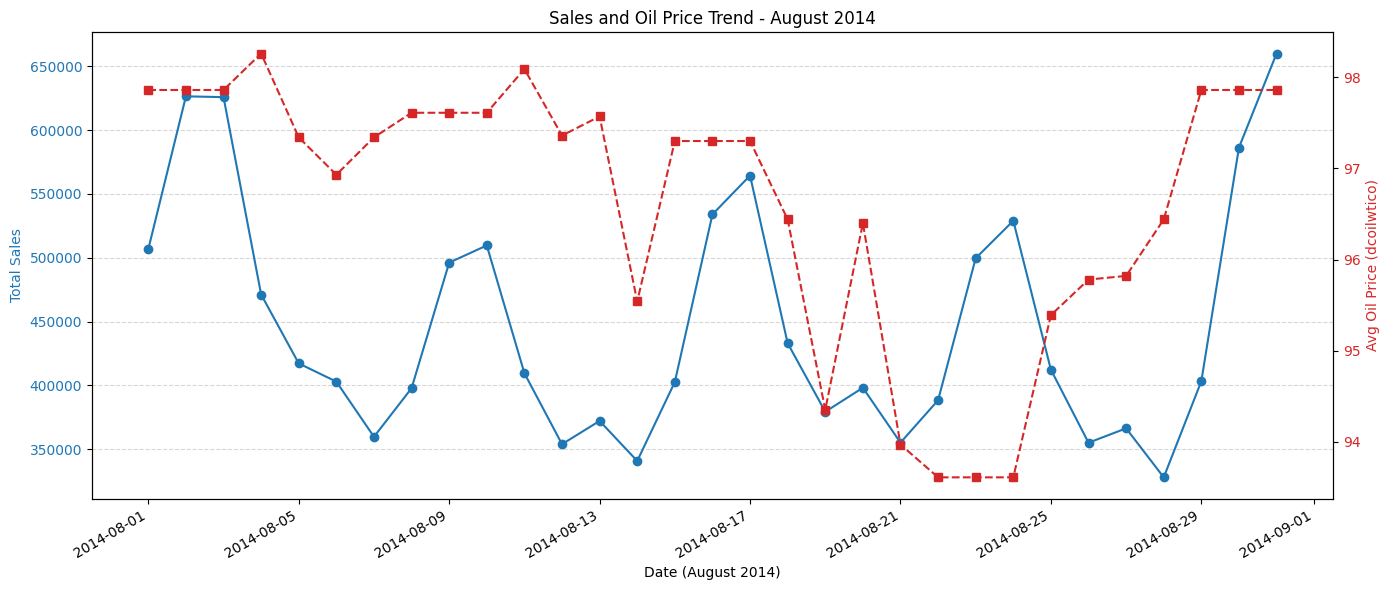

In [44]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 1. Filter Data for Each Year ---
df_2014 = daily_analysis[daily_analysis['Year'] == 2014].copy()
df_2017 = daily_analysis[daily_analysis['Year'] == 2017].copy()

# --- 2. Plot for August 2014 ---
fig_2014, ax1_2014 = plt.subplots(figsize=(14, 6))

# Sales on Primary Y-axis (Left)
color_sales = 'tab:blue'
ax1_2014.plot(df_2014['date'], df_2014['Total_Sales'], color=color_sales, marker='o', label='Total Sales (2014)')
ax1_2014.set_xlabel('Date (August 2014)')
ax1_2014.set_ylabel('Total Sales', color=color_sales)
ax1_2014.tick_params(axis='y', labelcolor=color_sales)
ax1_2014.grid(True, axis='y', linestyle='--', alpha=0.5)

# Oil Price on Secondary Y-axis (Right)
ax2_2014 = ax1_2014.twinx()
color_oil = 'tab:red'
ax2_2014.plot(df_2014['date'], df_2014['Avg_Oil_Price'], color=color_oil, linestyle='--', marker='s', label='Avg Oil Price (2014)')
ax2_2014.set_ylabel('Avg Oil Price (dcoilwtico)', color=color_oil)
ax2_2014.tick_params(axis='y', labelcolor=color_oil)

# Title and formatting
plt.title('Sales and Oil Price Trend - August 2014')
ax1_2014.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig_2014.autofmt_xdate()
fig_2014.tight_layout()
plt.show()

- The data shows no direct correlation between the steep daily drops in sales and the oil price in August 2014.

- Total Sales: Highly volatile with sharp, deep troughs (lows around Aug 7th and Aug 29th). The issue is likely daily/weekly seasonality or a localized/internal factor.

- Oil Price: Relatively stable, showing only a gradual, overall decline from $98 to $97.5 over the month. The sales volatility is not caused by a national economic shock (oil).

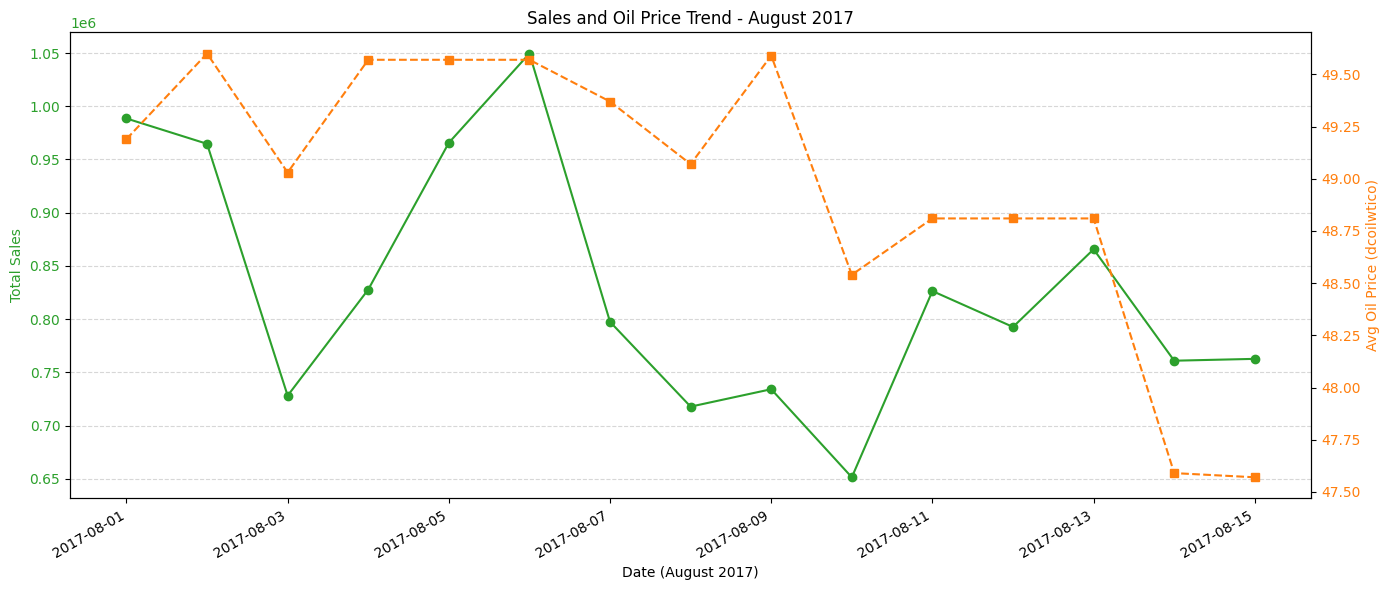

In [45]:
# --- 3. Plot for August 2017 ---
fig_2017, ax1_2017 = plt.subplots(figsize=(14, 6))

# Sales on Primary Y-axis (Left)
color_sales = 'tab:green'
ax1_2017.plot(df_2017['date'], df_2017['Total_Sales'], color=color_sales, marker='o', label='Total Sales (2017)')
ax1_2017.set_xlabel('Date (August 2017)')
ax1_2017.set_ylabel('Total Sales', color=color_sales)
ax1_2017.tick_params(axis='y', labelcolor=color_sales)
ax1_2017.grid(True, axis='y', linestyle='--', alpha=0.5)

# Oil Price on Secondary Y-axis (Right)
ax2_2017 = ax1_2017.twinx()
color_oil = 'tab:orange'
ax2_2017.plot(df_2017['date'], df_2017['Avg_Oil_Price'], color=color_oil, linestyle='--', marker='s', label='Avg Oil Price (2017)')
ax2_2017.set_ylabel('Avg Oil Price (dcoilwtico)', color=color_oil)
ax2_2017.tick_params(axis='y', labelcolor=color_oil)

# Title and formatting
plt.title('Sales and Oil Price Trend - August 2017')
ax1_2017.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig_2017.autofmt_xdate()
fig_2017.tight_layout()
plt.show()

- The severe sales collapse in August 2017 is not caused by the oil price trend because the sales drop precedes the steep oil price decline.

- Total Sales: Plummets suddenly from ≈$1.0M to ≈$650K, hitting the low around August 10th. Likely caused by a sudden, non-economic event (e.g., national strike, natural disaster, or major civic disruption).

- Oil Price: Stays high until August 9th, and only drops sharply on August 14th (after the main sales drop). The sales collapse is not tied to an immediate national economic shock (oil price). 